# Plink server usage



Content of `plink_analysis.sh` file:
#### 1) Create a binary dataset 

`plink --file wgas1 --make-bed --out wgas2`

Для начала разберемся с форматами. И так, у нас с приставкой wgas1 есть .map и .ped файлы.

a) `.ped` - contain genotype information (one person per row)

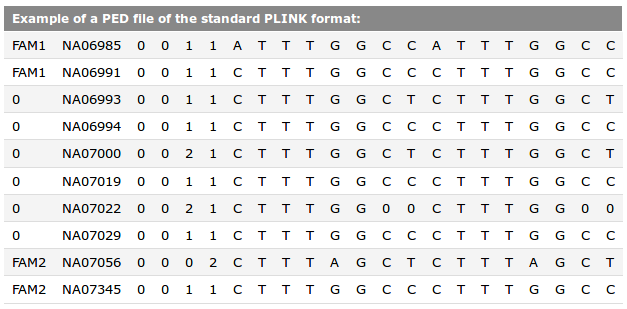

Columns:

* Family ID

* Sample ID

* Paternal ID

* Maternal ID
  
* Sex (1=male; 2=female; other=unknown)
  
* Affection (0=unknown; 1=unaffected; 2=affected) - 1 or 2 representing the first or second group
  
* Genotypes (space or tab separated, 2 for each marker. 0=missing) - Each pair of columns represents a particular SNP (SNP IDs are stored in the MAP file)

Также может содержать данные по фенотипу.


b) `.map` - contain information on the name and position of the markers in the PED file

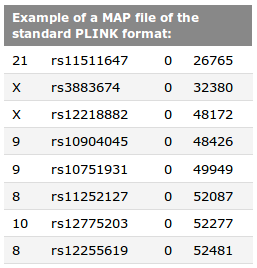

Columns:

* Chromosome

* Marker ID

* Genetic distance

* Physical position

После выполнения операции у нас выходит .bed, .bim, .fam и .log файлы.

a) `.bed` - are encoded in binary format. Contain genotype information. Primary representation of genotype calls at biallelic variants.

b) `.bim` -  an extended MAP file (*.bim) 

(which contains information about the allele names, which would otherwise be lost in the BED file).

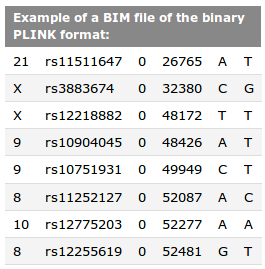

Columns:

* Chromosome
  
* Marker ID
  
* Genetic distance

* Physical position

* Allele 1
  
* Allele 2


c) `.fam` - contains sample information file accompanying a .bed binary genotype table.

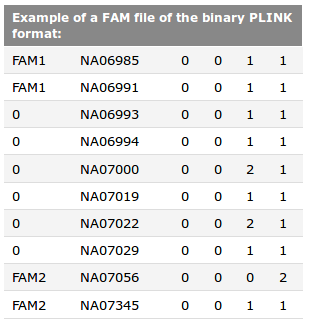

Columns:

* Family ID
  
* Sample ID
  
* Paternal ID
  
* Maternal ID

* Sex (1=male; 2=female; other=unknown)
  
* Affection (0=unknown; 1=unaffected; 2=affected)


d) `.log` - contains many critical details regarding the data, and any possible warnings or error messages.

From log file you can figure out numer of control and cases, gender, disease phenotypes etc.

Also there is number of SNPs which Minor allele frequency (MAF) is less than 0.05. This test allows to discard of rare variants. MAF is the frequency at which the second most common allele occurs in a given population. For example:

#### 2) Run data qc

`plink --bfile wgas2 --make-bed \
 --maf 0.01 \ 
 --geno 0.05 \ 
 --mind 0.05 \ 
 --hwe 0.001 \
 --out wgas3`
 
1) `maf` - trashhold for MAF test

2) `geno` - Missingness per marker (exclude SNPs on the basis of missing genotype rate)

3) `mind` -  Missingness per individual (exclude individuals with too much missing genotype data)

4) `hwe` - Hardy-Weinberg equilibrium (xclude markers that failure the Hardy-Weinberg test)

#### 3) Run relatedness analysis

`plink --bfile wgas3 --genome --out relatedness_alltogether --min 0.05`

Если есть желание больше углубиться в тему, то можно сгенерить IBS similarity matrix (plink.mibs), которая будет, которая будет содержать информацию о "родственности" аллелей у пары индивидуумов. 0 почти никогда не встречается, ибо чисто статистически два генотипа в некоторых позициях совпадут. Если 1, то, скорее всего, близнецы. 

Избавление от родственников в данном случае оправдывается искуственным увеличением частот некоторых аллелей, а это bias.

На выходе у нас два файла:

a) relatedness_alltogether.genome - список исключенных образцов.

Например:
```
FID1     IID1     ID2     IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  JA18942  NA18942  JA18966  NA18966 UN    NA  0.8979  0.1021  0.0000  0.0510   1  0.748891  0.9747  2.1403
```

b) relatedness_alltogether.log

#### 4) Read the file with relatedness estimation results and plot the PI_HAT distribution

 How many 3rd or higher degree relatives is there (PI_HAT >=0.125)?
 Remove related samples (keep only one from each pair with PI_HAT > 0.125)

#### 5) Perform LD-prunning of the data

Eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. It reduce number of SNPs in several times (For example, from 658,186 to 72,812.)

`plink --bfile wgas3 --indep 50 5 2` # 50 - window size, 5 - step

`plink --bfile wgas3 --extract plink.prune.in --make-bed --out wgas_pruned2`

#### 6) Perform PCA on the prunned data

PCA is one approach to visualizing and classifying individuals into
ancestry groups based on their observed genetic makeup. We do this for two reasons: First, self-
reported race and ethnicity can differ from clusters of individuals that are based solely on genetic
information, and second, the presence of an individual not appearing to fall within a racial/ethnic
cluster may be suggestive of a sample-level error.
 
 look for code in pca.r

#### 7) Select two clusters of ancestry and prepare a file, similar to pop.cov

#### 8) Run association test without stratification

`plink --bfile wgas3 --assoc --out non_stratified`

Output:

1) non_stratified.assoc

2) non_stratified.log

Example:

```
 CHR         SNP         BP   A1      F_A      F_U   A2        CHISQ            P           OR 
   1   rs3094315     792429    G   0.1489  0.08537    A        1.684       0.1944        1.875 
   1   rs4040617     819185    G   0.1354  0.08537    A        1.111       0.2919        1.678 
   1   rs4075116    1043552    C  0.04167  0.07317    T       0.8278       0.3629       0.5507 

```

#### 9) Run association test with stratification

`plink --bfile wgas3 --assoc --mh --within pop.cov`

#### 10) Create two qq-plots and estimate genomic inflation
 
 look for code in qq.r

#### 11) Create two manhattan plots

 look for code in manhattan.r

plink --bfile first --make-bed \
 --maf 0.01 \ 
 --geno 0.05 \ 
 --mind 0.05 \ 
 --hwe 0.001 \ 
 --out second_qc
 
plink --bfile second_qc --indep 50 5 2

plink --bfile plink --extract 10k.prune.in --make-bed --out wgas_pruned2_10k